Machine Learning models for obesity risk prediction

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import math
import sklearn as sk

In [2]:
# Load data
data = pd.read_csv("Data_collection_and_cleaning/processed_data/csv_files/Processed_data.csv",
                   header= 0)

Descriptive analysis

In [3]:
data.head(2)

,subjid,sex,age_days,age_years,date_of_measurement,height_cm,weight_kg,bmi,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,763,2.089023,2015-11-13,87.0,13.2,17.439556,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1118,3.060980,2016-11-02,96.0,15.9,17.252604,1.30,Overweight


In [4]:
print(f"Number of rows: {data.shape[0]}, Number of columns: {data.shape[1]}")

Number of rows: 247663, Number of columns: 10


In [5]:
data.describe()

,age_days,age_years,height_cm,weight_kg,bmi,zbmi
count,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000,247663.000000
mean,2302.077900,6.302875,117.018334,25.911639,17.422402,0.548033
std,1306.740792,3.577735,23.459458,15.057504,3.397402,1.316509
min,731.000000,2.001410,56.000000,4.750000,9.433962,-5.810000
25%,1129.000000,3.091097,97.000000,15.000000,15.231812,-0.340000
50%,2196.000000,6.012444,114.000000,20.400000,16.451348,0.450000
75%,3178.000000,8.701068,134.000000,32.500000,18.518263,1.360000
max,5478.000000,14.998255,202.000000,153.000000,48.836541,10.090000


In [6]:
# Check NA count
data.isna().sum()

subjid                 0
sex                    0
age_days               0
age_years              0
date_of_measurement    0
height_cm              0
weight_kg              0
bmi                    0
zbmi                   0
zbmi_type              0
dtype: int64

In [7]:
data.dtypes

subjid                  object
sex                     object
age_days                 int64
age_years              float64
date_of_measurement     object
height_cm              float64
weight_kg              float64
bmi                    float64
zbmi                   float64
zbmi_type               object
dtype: object

In [8]:
# Number of patients
len(data.subjid.unique())

62798

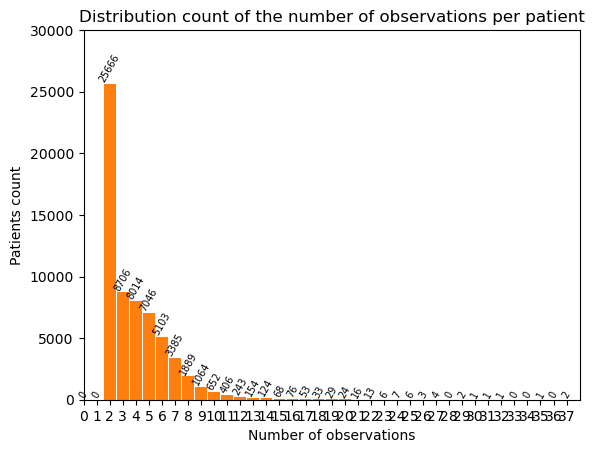

In [9]:
# Plot number of patients by number of obs
n_patients = data.value_counts("subjid")
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 30000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Distribution count of the number of observations per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Number of observations")

plt.show()

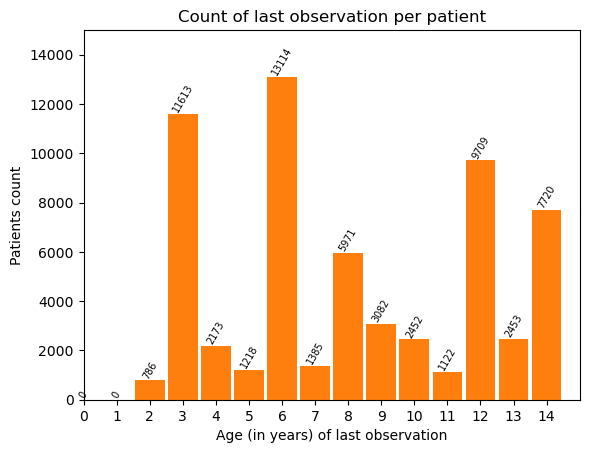

In [15]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 15000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

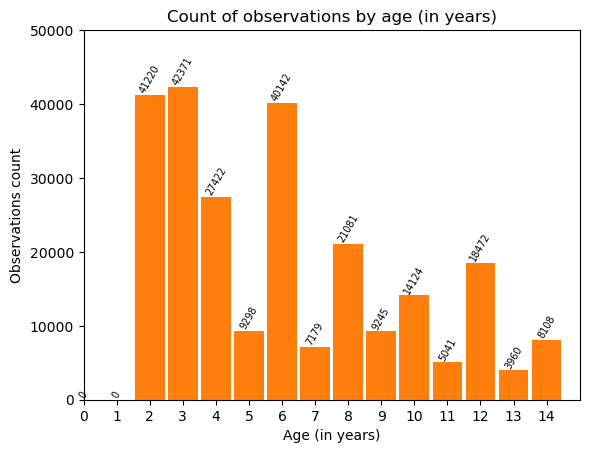

In [21]:
# Plot observations by age_years
n_patients = data.age_years.apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 50000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of observations by age (in years)")
ax.set_ylabel("Observations count")
ax.set_xlabel("Age (in years)")

plt.show()

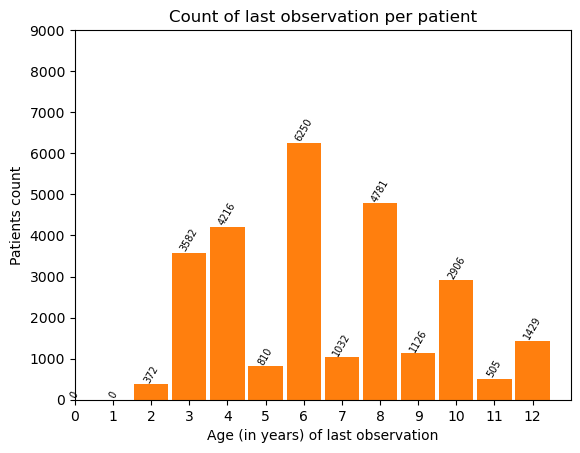

In [ ]:
# Plot number of patients by age_years of obs
n_patients = data.groupby("subjid")["age_years"].max().apply(math.trunc)
counts = np.bincount(n_patients)
n_bins = n_patients.max()
labels = range(n_bins+1)

fig, ax = plt.subplots()
ax.bar(labels, counts, width= 0.9, align= 'center')

ax.set(xticks= labels, xlim= [0, n_bins+1], ylim= [0, 9000])
ax.bar_label(ax.bar(labels, counts, width= 0.9, align= 'center'),
             counts, rotation= 60, fontsize= 7)
ax.set_title("Count of last observation per patient")
ax.set_ylabel("Patients count")
ax.set_xlabel("Age (in years) of last observation")

plt.show()

We will consider the following models for comparison: LSTM, GRU, Transformers, Random Forest, XGBoost, HMM, and Gaussian Processes.

To train the models reshaping of our data is needed so we have one row per patient.

In [25]:
# Filter data12
data["age_years"] = data["age_years"].apply(math.trunc)
data = data.loc[:, ["subjid", "sex", "age_years", "zbmi", "zbmi_type"]]
data.head(10)

,subjid,sex,age_years,zbmi,zbmi_type
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,1.24,Overweight
1,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,3,1.30,Overweight
2,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,4,0.73,Normal_weight
3,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,6,1.52,Overweight
4,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,8,1.70,Overweight
5,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,4,0.79,Normal_weight
6,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,6,0.66,Normal_weight
7,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,8,0.23,Normal_weight
8,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,10,0.59,Normal_weight
9,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,12,0.58,Normal_weight


Analysis of the zbmi trayectories by age:

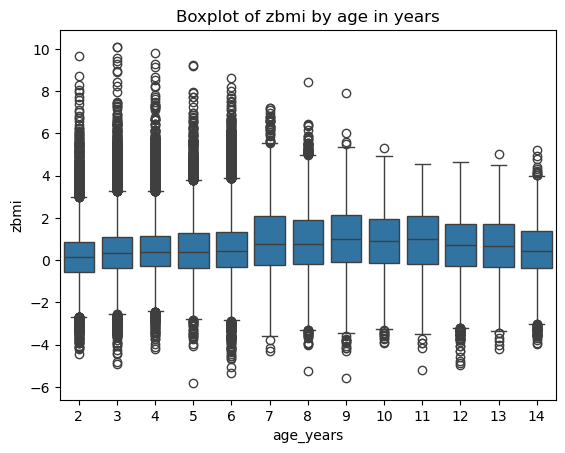

In [26]:
# Plot zbmi by age_years
sns.boxplot(x='age_years', y='zbmi', data=data)
plt.title("Boxplot of zbmi by age in years")
plt.show()

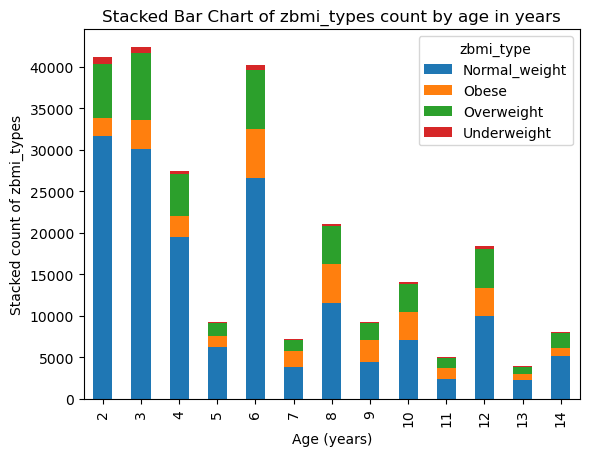

In [29]:
# Bar chart of each zbmi_type by age
stacked_counts = data.groupby(['age_years', 'zbmi_type']).size().unstack(fill_value=0)
stacked_counts.plot(kind='bar', stacked=True)

plt.xlabel('Age (years)')
plt.ylabel('Stacked count of zbmi_types')
plt.title('Stacked Bar Chart of zbmi_types count by age in years')

# Show the plot
plt.show()

In [30]:
# Reshape data
zbmi_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi", aggfunc="mean")
zbmi_types_pivoted = data.pivot_table(index=["subjid", "sex"], columns="age_years", values="zbmi_type", aggfunc="first")

# Combine multilevel columns
zbmi_pivoted.columns = [f"zbmi_{col}" for col in zbmi_pivoted.columns]
zbmi_types_pivoted.columns = [f"zbmi_type_{col}" for col in zbmi_types_pivoted.columns]

# Combine data
pivot_data = pd.merge(zbmi_pivoted, zbmi_types_pivoted, on=["subjid", "sex"], how="outer")
pivot_data.reset_index(inplace=True)

pivot_data.head(5)

,subjid,sex,zbmi_2,zbmi_3,zbmi_4,zbmi_5,zbmi_6,zbmi_7,zbmi_8,zbmi_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,1.24,1.30,0.73,NaN,1.52,NaN,1.70,NaN,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,NaN,NaN,0.79,NaN,0.66,NaN,0.23,NaN,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,NaN,NaN,1.43,NaN,1.77,NaN,2.92,3.13,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,Female,0.77,1.06,NaN,1.3,NaN,NaN,NaN,NaN,...,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,Male,NaN,0.63,NaN,NaN,0.83,NaN,NaN,NaN,...,NaN,Normal_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Add ages again
names = ["age_" + str(x) for x in range(2, 15, 1)]
ages = [x for x in range(2, 15, 1)]
age_dict = dict(zip(names, ages))

for agename, agevalue in age_dict.items():
    pivot_data[agename] = agevalue

# Reorder columns
age_cols = [col for col in pivot_data.columns if 'age' in col]

pivot_data = pivot_data[["subjid", "sex"] + 
                        age_cols + 
                        [col for col in pivot_data.columns if col not in age_cols and col not in ["subjid", "sex"]]]


pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_5,zbmi_type_6,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight


In [32]:
# Correct labels of zbmi_types
for i in range(2, 15, 1):
    typezbmi = f"zbmi_type_{i}"
    zbmi = f"zbmi_{i}"
    for index, row in pivot_data.iterrows():
        if i < 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 2.0 and value <= 3.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 3.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan
        if i >= 5:
            match row[zbmi]:
                case value if value < -2.0:
                    pivot_data.at[index, typezbmi] = "Underweight"
                case value if value >= -2.0 and value <= 1.0:
                    pivot_data.at[index, typezbmi] = "Normal_weight"
                case value if value > 1.0 and value <= 2.0:
                    pivot_data.at[index, typezbmi] = "Overweight"
                case value if value > 2.0:
                    pivot_data.at[index, typezbmi] = "Obese"
                case _:
                    pivot_data.at[index, typezbmi] = np.nan

In [33]:
# Encode sex variable
from sklearn.preprocessing import OneHotEncoder
sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(pivot_data["sex"].values.reshape(-1, 1))
sex_encoded_df = pd.DataFrame(sex_encoded, columns= sex_encoder.get_feature_names_out(['sex']))
pivot_data = pd.concat([pivot_data, sex_encoded_df], axis=1)

In [34]:
pivot_data.head(3)

,subjid,sex,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,...,zbmi_type_7,zbmi_type_8,zbmi_type_9,zbmi_type_10,zbmi_type_11,zbmi_type_12,zbmi_type_13,zbmi_type_14,sex_Female,sex_Male
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,Female,2,3,4,5,6,7,8,9,...,NaN,Overweight,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,Male,2,3,4,5,6,7,8,9,...,NaN,Normal_weight,NaN,Normal_weight,NaN,Normal_weight,NaN,NaN,0.0,1.0
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,Male,2,3,4,5,6,7,8,9,...,NaN,Obese,Obese,Obese,NaN,Obese,NaN,Normal_weight,0.0,1.0


In [35]:
# Check if the patient number is not affected
len(pivot_data)

62798

Data will be split between 67% train and 33% test, stratifying by label zbmi_type_14 to ensure we have data points at 14 years old in both train and test subsets.
Some models need further preparation after train-test split, so data will be prepared individually in order to maximize performance of each model. 

In [36]:
# Create a temporary column with combination of columns to stratify
pivot_data["stratify"] = pivot_data["sex"].astype(str) + "_" + pivot_data["zbmi_type_14"]
sex_column = pivot_data.pop("sex")

In [37]:
# Train-test split 67%-33%
y = pivot_data.pop("zbmi_14")

pivot_data["stratify"] = pivot_data["stratify"].fillna("Unknown")

zbmis = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]
pivot_data = pivot_data[[col for col in pivot_data.columns if '_type' not in col]]

xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(pivot_data.drop(columns=["age_14", "stratify"]),
                                                                   y,
                                                                   test_size=0.33,
                                                                   random_state=42,
                                                                   stratify=pivot_data["stratify"])
stratify_column = pivot_data.pop("stratify")

In [38]:
pivot_data.head(10)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male
0,++7gAwn0opdNQTTFGiAPCgz5uNuQtj3PT0yB,2,3,4,5,6,7,8,9,10,...,1.52,NaN,1.70,NaN,NaN,NaN,NaN,NaN,1.0,0.0
1,++8dJTQ553rK6jtUx8a0yAz5uNqftjnKSUuC,2,3,4,5,6,7,8,9,10,...,0.66,NaN,0.23,NaN,0.59,NaN,0.58,NaN,0.0,1.0
2,++E8IPijaucHmh/8YnpsyAz5uNqbvD7OSEGC,2,3,4,5,6,7,8,9,10,...,1.77,NaN,2.92,3.13,3.00,NaN,2.23,NaN,0.0,1.0
3,++FtKeESpTd0npbWZhKbKwz5udKbtTTDS02C,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
4,++H+79RWVcymBKRpLj7G0Qz5udOavTvIR0uC,2,3,4,5,6,7,8,9,10,...,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
5,++I9nc5fKbO/u4b1/2yTiQz5udKYvDzNTkGC,2,3,4,5,6,7,8,9,10,...,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
6,++L0bHwVuddtTPbPle9/ggz5uNubsDnCSkyG,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,1.37,NaN,1.0,0.0
7,++NsVGPHnkdWDpwjB16tQAz5udORsT7CR0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,2.13,NaN,1.0,0.0
8,++PF9XmuTG6SFeJwR1ZiBAz5udKctT7OSk6A,2,3,4,5,6,7,8,9,10,...,0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
9,++RKhV3ihA/cUyWtQJ+BFQz5udKQsT3CS0GB,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [39]:
# Dataframe shapes
print(f"Xtrain: number of rows = {xtrain.shape[0]}, number of columns = {xtrain.shape[1]}")
print(f"Xtest: number of rows = {xtest.shape[0]}, number of columns = {xtest.shape[1]}")
print(f"Ytrain: number of rows = {ytrain.shape[0]}")
print(f"Ytest: number of rows = {ytest.shape[0]}")

Xtrain: number of rows = 42074, number of columns = 27
Xtest: number of rows = 20724, number of columns = 27
Ytrain: number of rows = 42074
Ytest: number of rows = 20724


In [40]:
xtrain.head(3)

,subjid,age_2,age_3,age_4,age_5,age_6,age_7,age_8,age_9,age_10,...,zbmi_6,zbmi_7,zbmi_8,zbmi_9,zbmi_10,zbmi_11,zbmi_12,zbmi_13,sex_Female,sex_Male
25106,EiAE5NYdj56uflkYvwqsTQz5udObszrPSECD,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
36361,MIS7h3GhTWgHCOpWeprnEgz5uNuftD7ISkCH,2,3,4,5,6,7,8,9,10,...,0.81,NaN,1.09,NaN,NaN,NaN,1.6600,NaN,1.0,0.0
8380,3XG+IdpcK3uf23C+klJUxAz5udKevT3NSUuH,2,3,4,5,6,7,8,9,10,...,NaN,NaN,NaN,NaN,NaN,1.25,0.3925,NaN,0.0,1.0
